To-do:
- complete bayesian implemtation (reflect on prior choice, starting with simple Gaussian, choice of variance parameter)
- think about uncertainty for LIME in the case of CNN that are long to train 

In [ ]:
import torch 
import os 
import sys
from collections import Counter
from torchvision import datasets, transforms
import copy
from tqdm import tqdm
from urllib import request
import zipfile
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler

# Add parent directory to path BEFORE importing from src
sys.path.insert(0, '..')

from torchinfo import summary 
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc
from src.model_builder import XceptionCustom  
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image
from torch.autograd import Variable
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from sklearn.linear_model import LinearRegression
import lime
from lime import lime_image
from skimage.io import imread
from src.dataloaders import *
from src.utils import *
import warnings
from scipy.spatial.distance import pdist, squareform
from sklearn.linear_model import Ridge
from pathlib import Path 
# Suppress all warnings
warnings.filterwarnings('ignore')
from sklearn.metrics.pairwise import cosine_distances

from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import shortest_path
from skimage.measure import regionprops

import torch.nn.functional as F
from sklearn.metrics import pairwise_distances
import networkx as nx
from scipy.stats import multivariate_normal



In [8]:
test_dir = '/home/nlfrx7981/uncertainty/data/polar-lows/test'
train_dir = '/home/nlfrx7981/uncertainty/data/polar-lows/train'

# for local experiments 
# test_dir = '/Users/nicologrometto/Documents/interpretability/data/test'
# train_dir = '/Users/nicologrometto/Documents/interpretability/data/train'

device = get_device('auto')
print(device)

cuda


In [9]:
train_transform, test_transform = get_transforms() 
train_loader, test_loader, n_pos_train, n_neg_train, class_to_idx_dict = create_dataloaders(train_dir=train_dir,
                                                                                test_dir=test_dir,
                                                                                train_transform=train_transform,
                                                                                test_transform=test_transform)
print(class_to_idx_dict)

# Load the best model weights
model = XceptionCustom(input_channels=3)
model.load_state_dict(torch.load('../src/outputs/20.08.25_polar_lows_customex.pth'))

# for local experiments
# model.load_state_dict(torch.load('../models_local/trained_base_model.pth'))


# evaluate model 
y_pred_labels_np, y_true_np, y_pred_probs_np, misclassified_images, misclassified_true_labels, misclassified_pred_labels, misclassified_prob_vectors = evaluate_model(model, test_loader, device)

# Print classification report
print("\nClassification Report on Test Set:")
print(classification_report(y_true_np, y_pred_labels_np))
print(f"\nFound {len(misclassified_images)} misclassified images.")

Positive training samples: 254 (16%), Negative training samples: 1293 (83%)
{'neg': 0, 'pos': 1}

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       371
           1       0.92      0.95      0.94        64

    accuracy                           0.98       435
   macro avg       0.96      0.97      0.96       435
weighted avg       0.98      0.98      0.98       435


Found 8 misclassified images.


In [10]:
print(f'Size of misclassified images: {misclassified_images[0].shape}') 


Size of misclassified images: torch.Size([3, 512, 512])


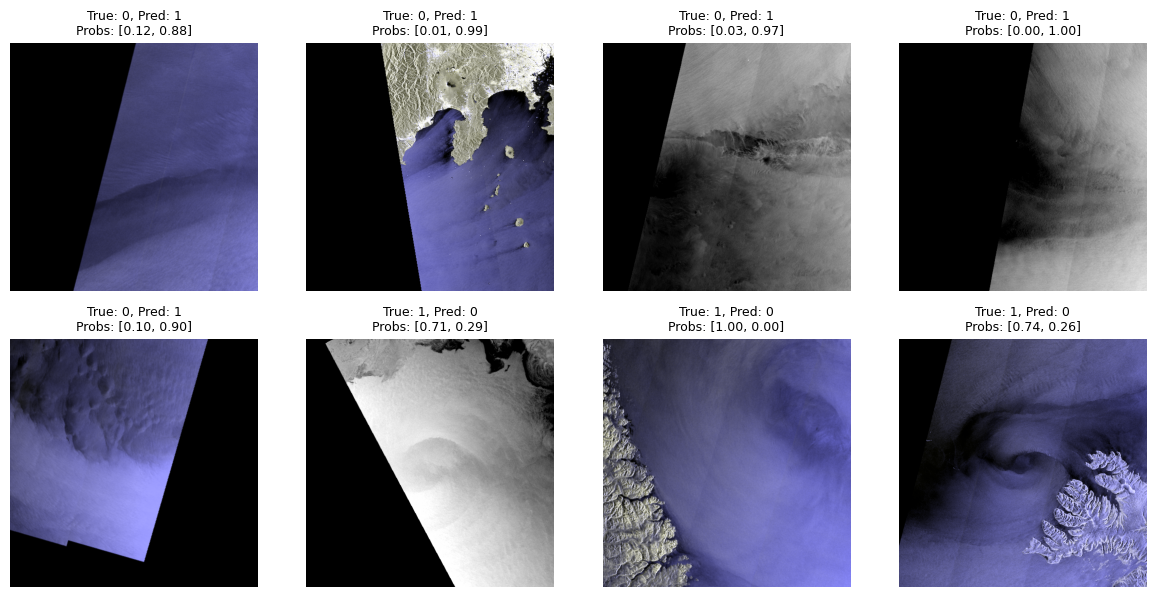

In [11]:
# --- plot misclassified images with probabilities ---
fig, axes = plt.subplots(4, 4, figsize=(12, 12)) # Create a 4x4 grid of subplots
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

for i in range(len(misclassified_images)):
    ax = axes[i]
    # Convert the image tensor (CHW) to NumPy array (HWC) for matplotlib
    img = misclassified_images[i].permute(1, 2, 0).numpy()
    ax.imshow(img)

    # Format the probability vector for display
    prob_vec = misclassified_prob_vectors[i].numpy()
    # Assuming two classes, e.g., [prob_neg, prob_pos]
    subtitle = f"True: {misclassified_true_labels[i]}, Pred: {misclassified_pred_labels[i]}\nProbs: [{prob_vec[0]:.2f}, {prob_vec[1]:.2f}]"
    ax.set_title(subtitle, fontsize=9) # Adjust fontsize as needed
    ax.axis('off') # Turn off the axes for each subplot

# Hide any unused subplots if fewer than 16 images are displayed
for j in range(len(misclassified_images), 16):
    fig.delaxes(axes[j])

plt.tight_layout() 
plt.show()

Original image size: (800, 800)
Transformed image shape: torch.Size([3, 512, 512])
Transformed image dtype: torch.float32
Transformed image range: [0.000, 1.000]


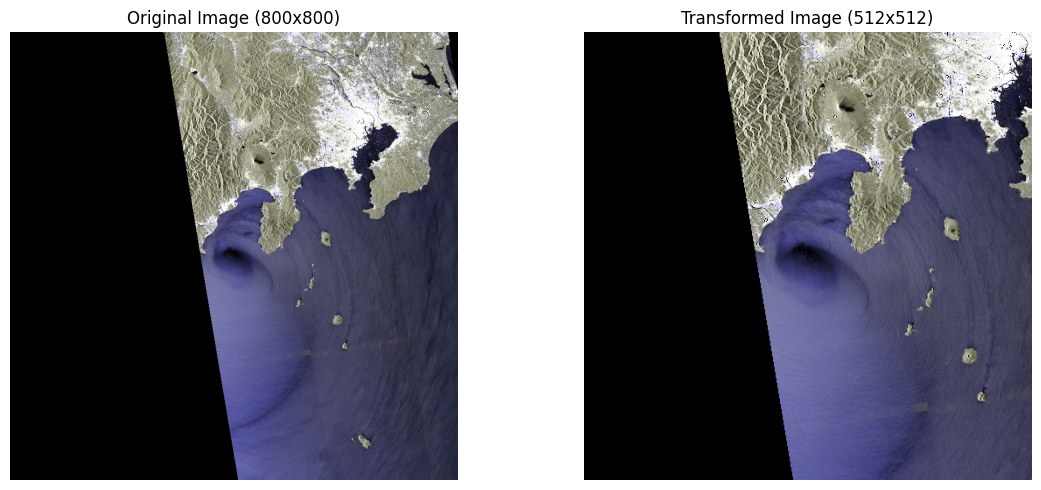

Batched image shape for model input: torch.Size([1, 3, 512, 512])
tensor([[0.0011, 0.9989]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


In [257]:
# Load sample image
image_path = Path(test_dir)/'pos'/'cffe42_20191012T084028_20191012T084212_mos_rgb.png'
image = get_image(image_path)

print(f"Original image size: {image.size}")

# Get the same transforms used for testing/inference
train_transform, test_transform = get_transforms()

# Apply the test transform (same as used during model evaluation)
transformed_image = test_transform(image)

print(f"Transformed image shape: {transformed_image.shape}")
print(f"Transformed image dtype: {transformed_image.dtype}")
print(f"Transformed image range: [{transformed_image.min():.3f}, {transformed_image.max():.3f}]")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Original image
axes[0].imshow(image)
axes[0].set_title(f"Original Image ({image.size[0]}x{image.size[1]})")
axes[0].axis('off')

# Transformed image (convert tensor back to displayable format)
# PyTorch tensors are in CHW format, matplotlib expects HWC
transformed_display = transformed_image.permute(1, 2, 0)  # CHW -> HWC
axes[1].imshow(transformed_display)
axes[1].set_title(f"Transformed Image ({transformed_image.shape[1]}x{transformed_image.shape[2]})")
axes[1].axis('off')

plt.tight_layout()
plt.show()

# The transformed_image now ready to be fed to model
# It's a tensor with shape (3, 512, 512) and values in [0, 1]

# for model inference:
batched_image = transformed_image.unsqueeze(0)  # Shape: (1, 3, 512, 512)
print(f"Batched image shape for model input: {batched_image.shape}")

model.eval()
logits_sample_img = model(batched_image.to(device))
print(torch.softmax(logits_sample_img, dim=1)) 

LIME image shape: (512, 512, 3)
Running LIME explanation...


100%|██████████| 1000/1000 [00:13<00:00, 74.92it/s]


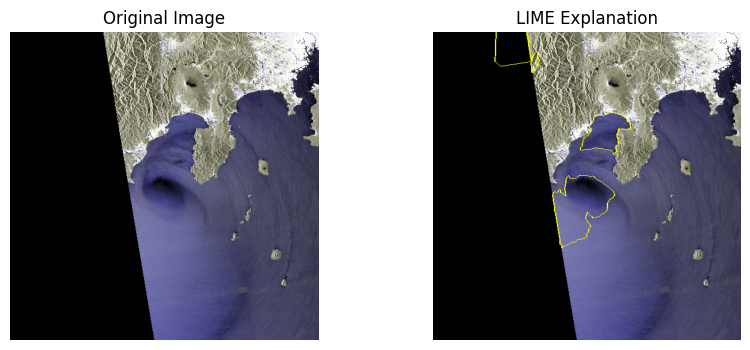

In [16]:
########
### COMPLETE LIME IMPLEMENTATION
########

# Convert tensor to numpy array for LIME
def prepare_image_for_lime(transformed_image):
    """Convert PyTorch tensor to numpy array format expected by LIME"""
    if isinstance(transformed_image, torch.Tensor):
        # Convert tensor to numpy
        img_np = transformed_image.detach().cpu().numpy()
        
        # If tensor is in CHW format (channels first), convert to HWC
        if img_np.shape[0] == 3 or img_np.shape[0] == 1:  # Check if channels first
            img_np = np.transpose(img_np, (1, 2, 0))  # CHW -> HWC
        
        # Ensure values are in [0, 255] range for LIME
        if img_np.max() <= 1.0:  # If normalized to [0,1]
            img_np = (img_np * 255).astype(np.uint8)
        else:
            img_np = img_np.astype(np.uint8)
            
        return img_np
    return transformed_image


def batch_predict(images):
    """
    Prediction function for LIME that converts numpy arrays back to tensors
    
    Args:
        images: numpy array of shape (batch_size, height, width, channels)
    Returns:
        numpy array of predictions
    """
    # Convert numpy array back to tensor format expected by your model
    if isinstance(images, np.ndarray):
        # Convert HWC to CHW format
        if len(images.shape) == 4:  # Batch of images
            images_tensor = torch.from_numpy(images).permute(0, 3, 1, 2).float()
        else:  # Single image
            images_tensor = torch.from_numpy(images).permute(2, 0, 1).float().unsqueeze(0)
        
        # Normalize to [0,1] if needed (if your model expects [0,1] range)
        if images_tensor.max() > 1.0:
            images_tensor = images_tensor / 255.0
            
        # Move to device if needed
        images_tensor = images_tensor.to(device)
    else:
        images_tensor = images
    
    # Get model predictions
    model.eval()
    with torch.no_grad():
        predictions = torch.softmax(model(images_tensor), dim=1)
        # Convert to numpy for LIME
        if isinstance(predictions, torch.Tensor):
            predictions = predictions.detach().cpu().numpy()
    
    return predictions


def custom_slic_segmentation(image, n_segments=100, compactness=10, start_label=1, sigma=1):
    return slic(image, n_segments=n_segments, compactness=compactness, 
                sigma=sigma, start_label=start_label)


# Running LIME
# Assume you have your transformed_image tensor from earlier
image = get_image(image_path)

# Convert tensor to format expected by LIME
lime_image_np = prepare_image_for_lime(transformed_image)

print(f"LIME image shape: {lime_image_np.shape}")

# Now run LIME explanation
print("Running LIME explanation...")
explainer_standard = lime_image.LimeImageExplainer()

explanation = explainer_standard.explain_instance(
    lime_image_np,  # Use numpy array instead of tensor
    batch_predict,  # Updated prediction function
    top_labels=2,   # For binary classification
    num_samples=1000,
    segmentation_fn=custom_slic_segmentation
)

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], # extract top class by prediction confidence
                                            positive_only=True, 
                                            num_features=5, 
                                            hide_rest=False)
'''
note: LIME doesn't automatically split the features 50/50 between positive and negative contributions. 
Instead, it selects the 10 most important features overall (by abs value) regardless of whether they're positive or negative contributions.
'''
img_boundry = mark_boundaries(temp/255.0, mask)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(np.array(lime_image_np))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_boundry)
plt.title('LIME Explanation')
plt.axis('off')
plt.show()

# Continuous LIME

Overall, seems less sensitive to randomness in the pertrbations, but more sensitive to segmentation into superpixels.
In addition, it seems to be less sensitive to the bandwidth parameter in weighted regression (with different choice of weights). This points to the idea of dropping the weights entirely, eliminating the need to choose a bandwidth parameter. 
The main idea is eliminate the need to downweight 'more extreme' perturbed samples of the original image as smoother sampling guarantees higher faithfullness and an implicit neighborhood encoding. 
More experiments are needed with Gaussian reweighting, instead of uniform. Is there a need for rescaling?

In [ ]:
def custom_slic_segmentation(image, n_segments=200, compactness=10, start_label=1, sigma=1):
    return slic(image, n_segments=n_segments, compactness=compactness, 
                sigma=sigma, start_label=start_label) 


def uniform_blurred_samples_vectorized(image, num_samples):
    """
    More efficient vectorized version.
    """
    # Generate superpixels
    segments = custom_slic_segmentation(image)
    unique_segments = np.unique(segments)
    
    # Generate all weights
    uniform_weights = np.random.uniform(0, 1, size=(num_samples, len(unique_segments)))
    
    # Convert image to float
    base_image = image.copy().astype(np.float32)
    
    # Create a mapping from segment IDs to indices for vectorization
    # This handles non-consecutive segment IDs
    seg_to_idx = {seg_id: idx for idx, seg_id in enumerate(unique_segments)}
    
    # Create index map for vectorized operations
    segment_indices = np.zeros_like(segments)
    for seg_id, idx in seg_to_idx.items():
        segment_indices[segments == seg_id] = idx
    
    samples = []
    for sample_idx in range(num_samples):
        # Create weight map for this sample
        weight_map = uniform_weights[sample_idx][segment_indices]
        
        # Apply weights (broadcast across color channels if needed)
        if len(base_image.shape) == 3:
            weight_map = weight_map[:, :, np.newaxis]
        
        blurred_image = base_image * weight_map
        
        # Normalize if needed
        if image.dtype == np.uint8:
            samples.append(blurred_image / 255.0)
        else:
            samples.append(blurred_image)
    
    return samples, segments, uniform_weights


def explain_image(image, n_samples=1000):
    """
    Generate explanation for an image using spatial coherence sampling
    """
    blurred_samples, _, uniform_weights = uniform_blurred_samples_vectorized(lime_image_np, n_samples)
    
    # Create perturbed images and get predictions
    predictions = []
    model.eval()
    
    for sample in tqdm(blurred_samples):
        
        # Convert perturbed image to tensor, permute to (C, H, W), add batch dim, move to device
        input_tensor = torch.from_numpy(sample).permute(2, 0, 1).unsqueeze(0).float().to(device)
        
        # Get model prediction
        with torch.inference_mode():
            logits = model(input_tensor)
            probs = torch.softmax(logits, dim=1)
            pred = probs.cpu().numpy()[0]
            predictions.append(pred)
    
    predictions = np.array(predictions)
    
    # Get prediction for original image
    input_orig = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0).float().to(device)
    with torch.inference_mode():
        orig_logits = model(input_orig)
        orig_probs = torch.softmax(orig_logits, dim=1).cpu().numpy()[0]
    
    target_class = np.argmax(orig_probs)
    y = predictions[:, target_class]
    
    ridge = Ridge(alpha=0.01) # practically irrelevant

    # uniform distance 
    #perturbation_distance = np.mean(np.abs(1 - uniform_weights), axis=1)
    #sample_weights = np.exp(-perturbation_distance / 2)

    # cosine dist weights 
    original_weights = np.ones(uniform_weights.shape[1])
    cosine_dist = cosine_distances(uniform_weights, original_weights.reshape(1, -1)).flatten()
    sample_weights = np.exp(-cosine_dist / 0.01)  


    ridge.fit(uniform_weights, y, sample_weight=sample_weights)
    #ridge.fit(uniform_weights, y)
    
    return ridge.coef_


def plot_top_k_segments_with_boundaries(img, segments_slic, beta, k=5, boundary_color=(1, 1, 0)):
    """
    Plot the original image with yellow boundaries around the union of the top-k most important superpixels.

    Args:
        img (np.ndarray): Original image, shape (H, W, C).
        segments_slic (np.ndarray): Superpixel labels, shape (H, W).
        beta (np.ndarray): Importance coefficients for each superpixel.
        k (int): Number of top superpixels to highlight.
        boundary_color (tuple): RGB color for the superpixel boundaries.
    """
    # Get top-k superpixel indices
    top_k_indices = np.argsort(beta)[-k:]

    # Create a mask to keep only top-k segments
    mask = np.isin(segments_slic, top_k_indices)

    # Create a new segment map where non-top-k segments are assigned a dummy label (-1)
    # and all top-k segments are merged into a single label (e.g., 0)
    masked_segments = np.full_like(segments_slic, fill_value=-1)
    masked_segments[mask] = 0  # merge all selected superpixels into one segment

    # Plot with yellow boundaries
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(mark_boundaries(img, masked_segments, color=boundary_color, mode='thick'))
    ax.set_title(f"Top-{k} Superpixels (Merged with Yellow Boundaries)")
    ax.axis('off')
    plt.show()


'''
def uniform_blurred_samples(image, num_samples, n_segments=100, compactness=10, sigma=1, start_label=1):
    """
    Generate multiple samples of uniformly blurred images using superpixels.
    """
    
    # Generate superpixels once 
    segments = slic(image, n_segments, compactness)
    unique_segments = np.unique(segments)
    
    # Generate ALL weights at once - shape (num_samples, n_superpixels)
    uniform_weights = np.random.uniform(0, 1, size=(num_samples, len(unique_segments)))
    
    # Convert image to float once
    base_image = image.copy().astype(np.float32)
    
    samples = []
    
    for sample_idx in range(num_samples):
        # Start with a fresh copy of the base image for each sample
        blurred_image = base_image.copy()
        
        # Apply the weights for THIS sample
        for i, segment_id in enumerate(unique_segments):
            mask = segments == segment_id
            blurred_image[mask] = blurred_image[mask] * uniform_weights[sample_idx, i]
        
        # Handle normalization 
        if image.dtype == np.uint8:
            samples.append(blurred_image / 255.0)  # Normalize uint8 images
        else:
            samples.append(blurred_image)  # Keep original scale for float images
    
    return samples, segments  # Return segments for potential reuse
'''
    
#blurred_samples, segments, uniform_weights = uniform_blurred_samples_vectorized(lime_image_np, 100)

'\ndef uniform_blurred_samples(image, num_samples, n_segments=100, compactness=10, sigma=1, start_label=1):\n    """\n    Generate multiple samples of uniformly blurred images using superpixels.\n    """\n\n    # Generate superpixels once \n    segments = slic(image, n_segments, compactness)\n    unique_segments = np.unique(segments)\n\n    # Generate ALL weights at once - shape (num_samples, n_superpixels)\n    uniform_weights = np.random.uniform(0, 1, size=(num_samples, len(unique_segments)))\n\n    # Convert image to float once\n    base_image = image.copy().astype(np.float32)\n\n    samples = []\n\n    for sample_idx in range(num_samples):\n        # Start with a fresh copy of the base image for each sample\n        blurred_image = base_image.copy()\n\n        # Apply the weights for THIS sample\n        for i, segment_id in enumerate(unique_segments):\n            mask = segments == segment_id\n            blurred_image[mask] = blurred_image[mask] * uniform_weights[sample_idx, i]\

100%|██████████| 10000/10000 [00:12<00:00, 770.93it/s]


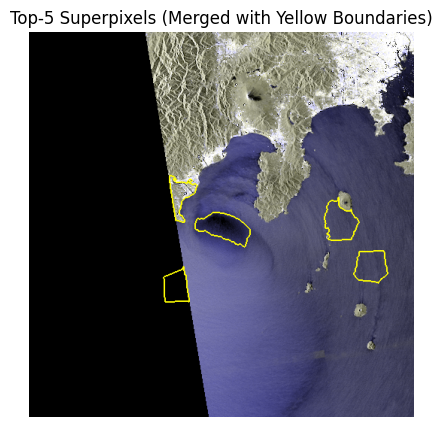

In [57]:
explanation = explain_image(lime_image_np, n_samples=10000)
plot_top_k_segments_with_boundaries(lime_image_np, segments, explanation, k=5, boundary_color=(1, 1, 0))

# Bayes LIME MGRF

In [254]:
class BayesLIME: 
    def __init__(self, model, image):
        self.model = model 
        self.image = image
        self.device = next(model.parameters()).device


    def slic_superpixels(self, image, n_superpixels=10, compactness=1):
        """
        Create superpixels using SLIC algorithm (labels starting at 0)
        
        Args:
            image: RGB image array (H, W, 3)
            n_superpixels: number of superpixels to create
            compactness: balance between color similarity and spatial proximity
        
        Returns:
            superpixels: label array (H, W) with superpixel IDs
        """
        superpixels = slic(
            image, 
            n_superpixels, 
            compactness,
            start_label=0,
            channel_axis=-1
        )
        return superpixels
    
    def get_superpixel_centers(self, superpixels):
        """Get centroid coordinates for each superpixel"""
        props = regionprops(superpixels + 1)  # regionprops expects 1-indexed labels
        centers = np.array([[prop.centroid[0], prop.centroid[1]] for prop in props])
        return centers

    
    def plot_image_boundaries_centers(self, image, superpixels, centers):
        plt.figure(figsize=(3, 3))
        plt.imshow(mark_boundaries(image, superpixels))

        # Unpack the centers into x and y for plotting
        y_coords, x_coords = zip(*centers)

        plt.scatter(x_coords, y_coords, c='red', s=30, marker='x')  # Plot centers
        plt.title('Superpixels with Centers')
        plt.show()


    
    def build_superpixel_graph(self, superpixels):
        """
        Build adjacency graph where superpixels are connected if they share a boundary
        Returns:
            adjacency_matrix: matrix (n_superpixels, n_superpixels) WITHOUT self-loops
            degree_matrix: diagonal matrix with degrees
        """
        n_superpixels = superpixels.max() + 1
        h, w = superpixels.shape
        
        # Find adjacent superpixels by checking 4-connectivity
        adjacencies = set()
        
        # Check horizontal adjacencies
        for i in range(h):
            for j in range(w - 1):
                if superpixels[i, j] != superpixels[i, j + 1]:
                    sp1, sp2 = superpixels[i, j], superpixels[i, j + 1]
                    adjacencies.add((min(sp1, sp2), max(sp1, sp2)))
        
        # Check vertical adjacencies
        for i in range(h - 1):
            for j in range(w):
                if superpixels[i, j] != superpixels[i + 1, j]:
                    sp1, sp2 = superpixels[i, j], superpixels[i + 1, j]
                    adjacencies.add((min(sp1, sp2), max(sp1, sp2)))
        
        # Build adjacency matrix without self-loops
        row_indices = []
        col_indices = []
        
        for sp1, sp2 in adjacencies:
            row_indices.extend([sp1, sp2])
            col_indices.extend([sp2, sp1])
            
        data = np.ones(len(row_indices))
        adjacency_matrix = csr_matrix((data, (row_indices, col_indices)),
                                    shape=(n_superpixels, n_superpixels)).toarray()
        
        # Calculate degrees (sum of each row - no self-loops to remove)
        degrees = np.array(adjacency_matrix.sum(axis=1)).flatten()
        degree_matrix = np.diag(degrees)
        
        return adjacency_matrix, degree_matrix
            

    def visualize_superpixel_graph(self, superpixels, centers, adjacency_matrix):
        """Visualize the superpixel adjacency graph as a network"""
        
        # Convert sparse matrix to NetworkX graph
        G = nx.from_numpy_array(adjacency_matrix)
        
        # Remove self-loops for visualization
        G.remove_edges_from(nx.selfloop_edges(G))
        
        plt.figure(figsize=(10, 4))
        
        # Plot 1: Original image with superpixels
        plt.subplot(1, 2, 1)
        plt.imshow(mark_boundaries(self.image, superpixels))
        y_coords, x_coords = zip(*centers)
        plt.scatter(x_coords, y_coords, c='red', s=30, marker='o')
        plt.title('Superpixels')
        plt.axis('off')
        
        # Plot 2: Graph structure
        plt.subplot(1, 2, 2)
        pos = {i: (centers[i][1], -centers[i][0]) for i in range(len(centers))}  # Note: flip y for plotting
        nx.draw(G, pos, node_size=100, node_color='lightblue', 
                edge_color='gray', alpha=0.7, with_labels=True, font_size=8)
        plt.title('Superpixel Adjacency Graph')
        plt.axis('equal')
        
        plt.tight_layout()
        plt.show()


    def build_MGRF_prior(self, adjacency_matrix, degree_matrix, eps=0.001):
        '''Return mean zero and precision matrix for GMRF'''
        n_superpixels = adjacency_matrix.shape[0]
        # Graph Laplacian
        laplacian = degree_matrix - adjacency_matrix
        # Add regularization
        precision_matrix = laplacian + eps * np.eye(n_superpixels)
        # Check eigenvalues before and after regularization
        eigenvals_before = np.linalg.eigvals(laplacian)
        eigenvals_after = np.linalg.eigvals(precision_matrix)
        
        return np.zeros(n_superpixels), precision_matrix
    

    
    def plot_superpixel_heatmap_prior_posterior(self, superpixels, prior_coefficients, posterior_coefficients):
        """
        Plot coefficient values mapped onto superpixels
        
        Args:
            superpixels: (H, W) array with superpixel labels
            coefficients: (n_superpixels,) array of coefficient values
            title: plot title
        """
        # Create coefficient maps
        coeff_map_prior = np.zeros_like(superpixels, dtype=float)
        
        for sp_id in range(len(prior_coefficients)):
            mask = (superpixels == sp_id)
            coeff_map_prior[mask] = prior_coefficients[sp_id]

        coeff_map_posterior = np.zeros_like(superpixels, dtype=float)
        
        for sp_id in range(len(posterior_coefficients)):
            mask = (superpixels == sp_id)
            coeff_map_posterior[mask] = posterior_coefficients[sp_id]
        
        plt.figure(figsize=(12, 12))
        
        # Original image
        plt.subplot(1, 3, 1)
        plt.imshow(self.image)
        plt.title('Original Image')
        plt.axis('off')
        
        # Coefficient heatmap prior
        plt.subplot(1, 3, 2)
        im = plt.imshow(coeff_map_prior, cmap='RdBu_r', alpha=0.9)
        plt.title('Prior coeff')
        plt.colorbar(im, fraction=0.046, pad=0.04)
        plt.axis('off')

        # Coefficient heatmap posterior
        plt.subplot(1, 3, 3)
        im = plt.imshow(coeff_map_posterior, cmap='RdBu_r', alpha=0.9)
        plt.title('Posterior coeff')
        plt.colorbar(im, fraction=0.046, pad=0.04)
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()


    def uniform_blurred_samples_vectorized(self, image, superpixels, n_samples):
        """
        More efficient vectorized version.
        """
        unique_superpixels = np.unique(superpixels)
        
        # Generate all weights
        uniform_weights = np.random.uniform(0, 1, size=(n_samples, len(unique_superpixels)))
        
        # Convert image to float
        base_image = image.copy().astype(np.float32)
        
        # Create a mapping from segment IDs to indices for vectorization
        # This handles non-consecutive segment IDs
        seg_to_idx = {seg_id: idx for idx, seg_id in enumerate(unique_superpixels)}
        
        # Create index map for vectorized operations
        segment_indices = np.zeros_like(superpixels)
        for seg_id, idx in seg_to_idx.items():
            segment_indices[superpixels == seg_id] = idx
        
        samples = []
        for sample_idx in range(n_samples):
            # Create weight map for this sample
            weight_map = uniform_weights[sample_idx][segment_indices]
            
            # Apply weights (broadcast across color channels if needed)
            if len(base_image.shape) == 3:
                weight_map = weight_map[:, :, np.newaxis]
            
            blurred_image = base_image * weight_map
            
            # Normalize if needed
            if image.dtype == np.uint8:
                samples.append(blurred_image / 255.0)
            else:
                samples.append(blurred_image)
        
        return samples, uniform_weights
    

    
    def model_predictions_perturbations(self, image, superpixels, n_samples=1000):
        """
        Generate model predictions on perturbations and extract probabilities for target class
        
        Args:
            image: original image array
            superpixels: superpixel segmentation 
            n_samples: number of perturbation samples
        
        Returns:
            y: target class probabilities for perturbed samples
            uniform_weights: perturbation weights for each sample
            target_class: the predicted class for original image
        """
        # Generate samples and weights
        samples, uniform_weights = self.uniform_blurred_samples_vectorized(image, superpixels, n_samples)
        
        # Create perturbed images and get predictions
        predictions = []
        self.model.eval()  # Use self.model
        
        for sample in tqdm(samples):
            # Convert perturbed image to tensor, permute to (C, H, W), add batch dim, move to device
            input_tensor = torch.from_numpy(sample).permute(2, 0, 1).unsqueeze(0).float().to(self.device)
            
            # Get model prediction
            with torch.inference_mode():
                logits = self.model(input_tensor)  # Use self.model
                probs = torch.softmax(logits, dim=1)
                pred = probs.cpu().numpy()[0]
                predictions.append(pred)
        
        predictions = np.array(predictions)
        
        # Get prediction for original image
        input_orig = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0).float().to(self.device)
        with torch.inference_mode():
            orig_logits = self.model(input_orig)  # Use self.model
            orig_probs = torch.softmax(orig_logits, dim=1).cpu().numpy()[0]
        
        target_class = np.argmax(orig_probs)
        y = predictions[:, target_class]  # Extract target class probabilities
        
        return y, uniform_weights, target_class



    def build_MGRF_posterior(self, prior_precision, uniform_weights, y, sigma=0.1):   # simplest case with iid error terms
        posterior_precision = prior_precision + sigma**(-2)*np.dot(uniform_weights.T, uniform_weights)
        posterior_mean = np.dot(np.linalg.inv(posterior_precision), sigma**(-2)*np.dot(uniform_weights.T, y))
        return posterior_mean, posterior_precision

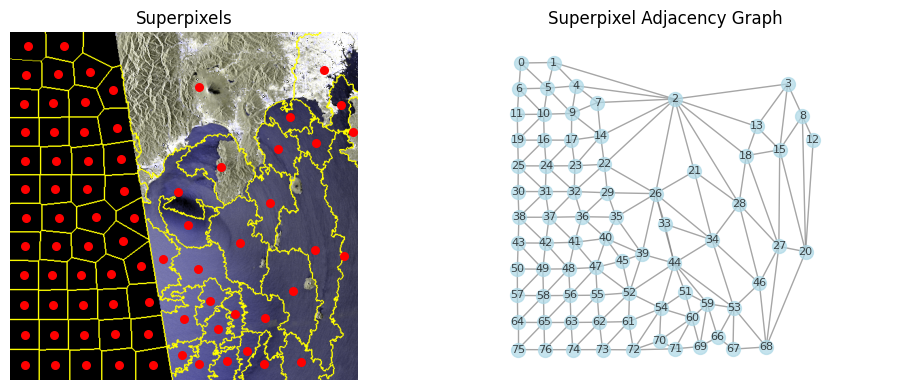

100%|██████████| 1000/1000 [00:01<00:00, 712.13it/s]


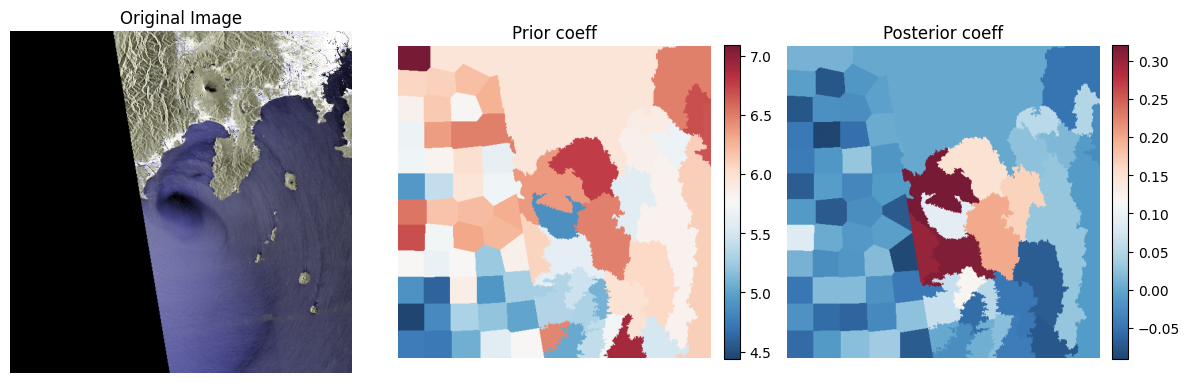

Model predictions: tensor([[0.0011, 0.9989]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


In [258]:
explainer = BayesLIME(model, lime_image_np)
superpixels = explainer.slic_superpixels(lime_image_np, n_superpixels=150, compactness=1)
centers = explainer.get_superpixel_centers(superpixels)
adjacency_matrix, degree_matrix = explainer.build_superpixel_graph(superpixels)
explainer.visualize_superpixel_graph(superpixels, centers, adjacency_matrix)
prior_mean, prior_precision = explainer.build_MGRF_prior(adjacency_matrix, degree_matrix)
prior_example = multivariate_normal.rvs(prior_mean, np.linalg.inv(prior_precision), size=1)
y, uniform_weights, target_class = explainer.model_predictions_perturbations(lime_image_np, superpixels, n_samples=1000)
posterior_mean, posterior_precision = explainer.build_MGRF_posterior(prior_precision, uniform_weights, y, sigma=0.1)

posterior_example = multivariate_normal.rvs(posterior_mean, np.linalg.inv(posterior_precision), size=1)
explainer.plot_superpixel_heatmap_prior_posterior(superpixels, prior_example, posterior_example)
print(f'Model predictions: {torch.softmax(logits_sample_img, dim=1)}') 

Next: visualize boundary of most important superpixels with standard deviation associated with it (uncertainty associated with linear surrogate approximation) \\
Attempt to use different covariance for likelihood and different ways of approximating it, assuming dependence for example (estimate from data vs set additional prior on it vs fit sigma parameter under independence assumption)\\
Test same approach on other images\\
Attempt to use binary features as well  \\

Preliminary conlclusions: high dependence on segmentation parameters (peril: injecting personal bias into what the model actually sees). 